In [1]:
#John Gizis
#Plot parallax observations for a given LSST simulation. adopted from Peter Yoachim's code at https://github.com/yoachim/LSST-BD-Cadence/blob/main/Pass_example.ipynb

#note this uses rubin_sim 

In [2]:

import rubin_sim.maf.utils as mafUtils

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import rubin_sim.maf.db as db
import rubin_sim.maf.utils as utils
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metricBundles as metricBundles
import rubin_sim.maf.plots as plots
import rubin_sim.maf.maps as maps


In [3]:
#choose location for plotting

#random spot in main survey
#ra0=0
#dec0=-20

# ...or...
ra0=9.45
dec0= -44
#This is a deep drilling field! 

In [4]:
dbFile = '/sims_maf/fbs_2.0/baseline/baseline_v2.0_10yrs.db' 
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='illustrate'
resultsDb = db.ResultsDb(outDir=outDir)

In [5]:
bundleList = []
#sql = 'filter="z" or filter="y"'
sql = 'visitExposureTime > 14.'
metric = metrics.PassMetric(cols=['filter', 'fiveSigmaDepth', 'ra_pi_amp',
                                  'dec_pi_amp', 'seeingFwhmGeom','observationStartMJD'
                                 ])
slicer = slicers.UserPointsSlicer(ra=ra0, dec=dec0)
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             runName=runName))


In [6]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database observations with constraint visitExposureTime > 14. for columns ['fiveSigmaDepth', 'filter', 'observationStartMJD', 'fieldDec', 'fieldRA', 'rotSkyPos', 'seeingFwhmGeom']
Found 2086980 visits
Running:  ['_sims_maf_fbs_2_0_baseline_baseline_v2_0_10yrs_Pass_filter_fiveSigmaDepth_ra_pi_amp_dec_pi_amp_seeingFwhmGeom_observationStartMJD_visitExposureTime_gt_14_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [7]:
bundleList[0].metricValues[0].dtype
dataSlice = bundleList[0].metricValues[0]

In [8]:
dataSlice.dtype


dtype([('fiveSigmaDepth', '<f8'), ('filter', '<U256'), ('observationStartMJD', '<f8'), ('fieldDec', '<f8'), ('fieldRA', '<f8'), ('rotSkyPos', '<f8'), ('seeingFwhmGeom', '<f8'), ('ra_pi_amp', '<f8'), ('dec_pi_amp', '<f8')])

In [9]:
# Here's the parallax amplitude. I'll just assume a 1" parallax star, but could multiply by any factor.
parallax_amplitude = (dataSlice['ra_pi_amp']**2 + dataSlice['dec_pi_amp']**2)**0.5
star_mag = 20.  # Just assume a flat SED. This is used in the estimate of the uncertainty.
snr = parallax_amplitude*0
atm_err = 0.01

for filt in np.unique(dataSlice['filter']):
    good = np.where(dataSlice['filter'] == filt)
    snr[good] = mafUtils.m52snr(star_mag, dataSlice['fiveSigmaDepth'][good])
position_errors = np.sqrt(mafUtils.astrom_precision(dataSlice['seeingFwhmGeom'],
                                                            snr)**2+atm_err**2)

Text(0, 0.5, 'Parallax Amplitude (arcsec)')

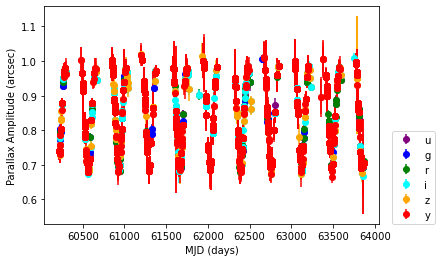

In [10]:
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
           'i': 'cyan', 'z': 'orange', 'y': 'red'}

for filt in 'ugrizy':
    good = np.where(dataSlice['filter'] == filt)
    plt.errorbar(dataSlice['observationStartMJD'][good], parallax_amplitude[good], yerr=position_errors[good],
                color=f2c[filt], fmt='o', label=filt)
plt.legend(loc=(1.04,0))
plt.xlabel('MJD (days)')
plt.ylabel('Parallax Amplitude (arcsec)')

In [11]:
izy = np.where((dataSlice['filter'] == 'z')|(dataSlice['filter'] == 'y'))
iz = np.where(dataSlice['filter'] == 'z')
iy = np.where(dataSlice['filter'] == 'y')
            

In [12]:
plot_base = """plot_base20_ddf_{plottype}_{ra}_{dec}.{ftype}"""


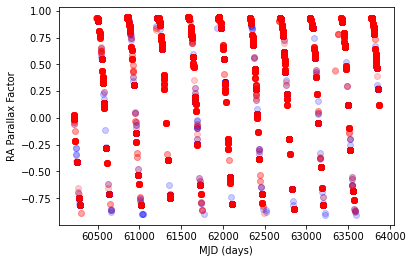

In [13]:
plt.plot(dataSlice['observationStartMJD'][iz],dataSlice['ra_pi_amp'][iz],'o',color='blue',alpha=0.2)
plt.plot(dataSlice['observationStartMJD'][iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.2)
plt.xlabel('MJD (days)')
plt.ylabel('RA Parallax Factor')   
plotname=plot_base.format(plottype='MJD_RAP',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)

In [14]:
days_since_start = dataSlice['observationStartMJD'] - np.min(dataSlice['observationStartMJD'])
years_since_start = days_since_start / 365.25636        #am I using right length of year? 
phase_years = years_since_start % 1

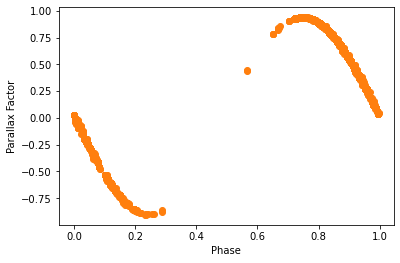

In [15]:
plt.plot(phase_years[izy],dataSlice['ra_pi_amp'][izy],'o',color='C1')
plt.xlabel('Phase')
plt.ylabel('Parallax Factor')   
plotname=plot_base.format(plottype='Phase_PF',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)


In [16]:
np.size(dataSlice['ra_pi_amp'][izy])

6551

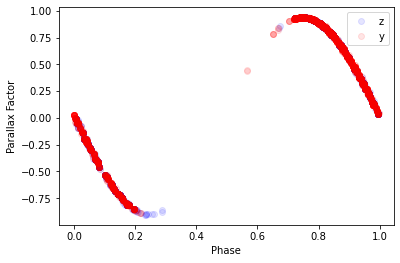

In [17]:
plt.plot(phase_years[iz],dataSlice['ra_pi_amp'][iz],'o',color='blue',alpha=0.1,label='z')
plt.plot(phase_years[iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.1,label='y')
plt.xlabel('Phase')
plt.ylabel('Parallax Factor');
plt.legend()
plotname=plot_base.format(plottype='Phase_PF',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)



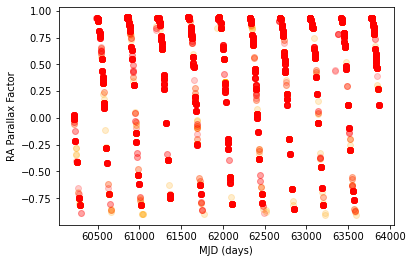

In [18]:
plt.plot(dataSlice['observationStartMJD'][iz],dataSlice['ra_pi_amp'][iz],'o',color='orange',alpha=0.2)
plt.plot(dataSlice['observationStartMJD'][iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.2)
plt.xlabel('MJD (days)')
plt.ylabel('RA Parallax Factor')  
plotname=plot_base.format(plottype='MJD_RAP_zy',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)




In [19]:
print(np.max(dataSlice['ra_pi_amp'][iy]),np.min(dataSlice['ra_pi_amp'][iy]))

0.940624539467821 -0.8919816078974613


In [20]:
from astropy.table import QTable, Table, Column
from astropy import units as u

In [21]:
parallax_table = Table()
parallax_table['MJD'] = dataSlice['observationStartMJD'][izy]
parallax_table['ra_pi_amp'] = dataSlice['ra_pi_amp'][izy]
parallax_table['dec_pi_amp'] = dataSlice['dec_pi_amp'][izy]
parallax_table['filter'] = dataSlice['filter'][izy]
parallax_table['seeingFWHM'] = dataSlice['seeingFwhmGeom'][izy]
parallax_table['snr'] = snr[izy]
parallax_table['position_errors'] = position_errors[izy]
parallax_table['fiveSigmaDepth'] = dataSlice['fiveSigmaDepth'][izy]
parallax_table['fieldRA'] = dataSlice['fieldRA'][izy]
parallax_table['fieldDec'] = dataSlice['fieldDec'][izy]




In [22]:
parallax_table

MJD,ra_pi_amp,dec_pi_amp,filter,seeingFWHM,snr,position_errors,fiveSigmaDepth,fieldRA,fieldDec
float64,float64,float64,str256,float64,float64,float64,float64,float64,float64
63197.035155946425,-0.7400073630262014,-0.6396598371087219,z,0.7459110516021081,68.66071451342239,0.01476551722715334,22.84434578558884,9.238127133689332,-45.936368355039924
63167.165647955124,-0.36399086056603247,-0.7963511150891543,y,0.6099703959888674,45.48623071074032,0.016728063990118072,22.39727486369528,10.150297519798926,-45.77388350199807
60222.33682121577,-0.05306921749937287,-0.7556960392383572,z,1.034144126045006,53.41303476063083,0.021791253553794444,22.571693123951427,7.639067512976381,-45.20155707874225
60222.36226731477,-0.05347053304538103,-0.7557848393843649,y,0.940180808950657,24.780401237867583,0.03923622723127362,21.737845824363077,7.639067512976381,-45.20155707874225
61625.32546887137,0.7595770665223714,-0.24249426774244237,z,0.8134658622682027,85.74762698973139,0.013783988124947133,23.08563026431358,8.702782806028866,-45.765791058810024
62346.39766892505,0.8333985113091514,-0.11328560442542741,z,1.0606886677107792,49.561470804065564,0.02362251488152274,22.49043545459695,8.623272273600051,-45.017643972107834
61036.07813307258,-0.8991822769462048,-0.2893373350125683,z,0.666185325073965,91.67742381171152,0.012361384126874283,23.158230991335667,7.634596748594117,-45.03127736259173
60543.35486833781,0.601490242772842,-0.4102255169863993,y,0.6841587977118323,37.24361597329463,0.020915318769484218,22.180204588905514,7.935057182968595,-45.53497940612371
62346.407539166416,0.8333277144972644,-0.11341684256953426,z,1.0375193867896866,50.53818330910389,0.022835431230335646,22.511624054973076,8.623272273600051,-45.017643972107834


In [23]:
from astropy.io import ascii

In [24]:
out_base = """data_base20_ddf_{datatype}_{ra}_{dec}.{ftype}"""
outname_tbl=out_base.format(datatype='parallax',ra=ra0,dec=dec0,ftype='tbl')
outname_csv=out_base.format(datatype='parallax',ra=ra0,dec=dec0,ftype='csv')


In [25]:
#ascii.write(parallax_table,outname_tbl,format='ipac')

In [26]:
ascii.write(parallax_table,outname_csv,format='ecsv')

(array([0.2529759 , 0.39351807, 0.41501275, 0.27116371, 0.1421956 ,
        0.25628277, 0.23478809, 0.27777746, 0.14715592, 0.24305528,
        0.19014528, 0.52744649, 0.34556839, 0.55059461, 0.43320056,
        0.63822678, 0.5770496 , 0.58531679, 1.17394045, 3.17625297]),
 array([-0.90581324, -0.81349135, -0.72116946, -0.62884757, -0.53652568,
        -0.44420379, -0.3518819 , -0.25956001, -0.16723813, -0.07491624,
         0.01740565,  0.10972754,  0.20204943,  0.29437132,  0.38669321,
         0.4790151 ,  0.57133698,  0.66365887,  0.75598076,  0.84830265,
         0.94062454]),
 [<matplotlib.patches.Polygon at 0x7fa41c7f46d0>])

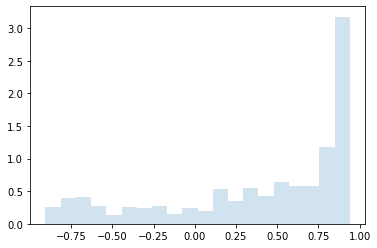

In [27]:
plt.hist(parallax_table['ra_pi_amp'],bins=20,histtype='stepfilled', alpha=0.2, density=True)


(array([0.00076852, 0.00642089, 0.0144532 , 0.02503899, 0.02541085,
        0.02127074, 0.01415571, 0.00627214, 0.00624735, 0.00570195,
        0.00609861, 0.00788356, 0.00617298, 0.00530529, 0.00384262,
        0.00237994, 0.00272702, 0.00109081, 0.0008429 , 0.00032228]),
 array([ 12.0212404 ,  18.17863507,  24.33602974,  30.4934244 ,
         36.65081907,  42.80821373,  48.9656084 ,  55.12300307,
         61.28039773,  67.4377924 ,  73.59518707,  79.75258173,
         85.9099764 ,  92.06737106,  98.22476573, 104.3821604 ,
        110.53955506, 116.69694973, 122.85434439, 129.01173906,
        135.16913373]),
 [<matplotlib.patches.Polygon at 0x7fa41c79d4c0>])

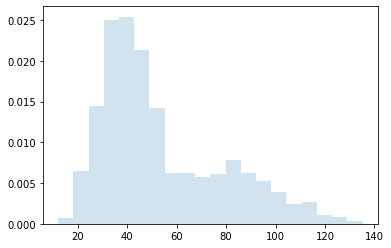

In [28]:
plt.hist(parallax_table['snr'],bins=20,histtype='stepfilled', alpha=0.2, density=True)



(array([0.00348603, 0.01045808, 0.01278209, 0.04183231, 0.16965325,
        0.13711701, 0.38927286, 0.42529513, 0.71579726, 1.04348367,
        0.87964047, 0.82270205, 0.57403222, 0.30212222, 0.37184273,
        0.4485353 , 0.59262436, 0.36254667, 0.23007769, 0.07901658]),
 array([20.9524482 , 21.08381423, 21.21518026, 21.34654629, 21.47791232,
        21.60927835, 21.74064438, 21.87201041, 22.00337644, 22.13474247,
        22.26610851, 22.39747454, 22.52884057, 22.6602066 , 22.79157263,
        22.92293866, 23.05430469, 23.18567072, 23.31703675, 23.44840278,
        23.57976882]),
 [<matplotlib.patches.Polygon at 0x7fa41c3445b0>])

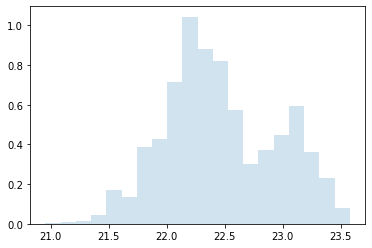

In [29]:
plt.hist(parallax_table['fiveSigmaDepth'],bins=20,histtype='stepfilled', alpha=0.2, density=True)

